# Drifting Models: A Step-by-Step Demo

**Paper:** Generative Modeling via Drifting

This demo walks you through the core algorithm with hands-on examples:

1. **Part 1: Core Algorithm** — The drifting loss and drift computation
2. **Part 2: Toy 2D** — Visualize dynamics on swiss roll & checkerboard

**More samples and full results can be found in the paper.**

---

# Install packages

In [1]:
!pip install -q matplotlib numpy torch torchvision tqdm einops scipy pot


In [2]:
import os
import sys
import math
from collections import OrderedDict
from functools import partial

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import ot
from scipy.optimize import linear_sum_assignment
from tqdm.auto import tqdm

# Device selection
# - In Colab: prefer CUDA (GPU) and warn if GPU isn't enabled
# - Locally: prefer CUDA, then Apple Silicon MPS, then CPU
IN_COLAB = (
    "google.colab" in sys.modules
    or os.environ.get("COLAB_GPU") is not None
    or os.environ.get("COLAB_TPU_ADDR") is not None
)

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif (not IN_COLAB) and torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

print(f"Using device: {DEVICE} (IN_COLAB={IN_COLAB})")
if IN_COLAB and DEVICE.type != "cuda":
    print(
        "[Warning] Colab is not running with GPU enabled. Please select 'Runtime -> Change runtime type -> GPU' in the menu and re-run this cell."
    )


Using device: cuda (IN_COLAB=False)


# Part 1: Core Algorithm

**Traditional generative models** (Diffusion, Flow Matching) iterate at **inference time**.

**Drifting Models** move the iteration to **training time**:
- Each training step "drifts" the generated samples according to a drifting field
- At inference: just one forward pass (1 NFE)

## Training Objective

Given a generator $f_\theta$ that maps noise $\epsilon$ to samples, the training loss is:

$$
L = \mathbb{E}_{\epsilon} \Big[ \big\| f_\theta(\epsilon) - \text{stopgrad}\big(f_\theta(\epsilon) + \mathbf{V}_{p,q}(f_\theta(\epsilon))\big) \big\|^2 \Big]
$$

We move predictions toward their **drifted** versions. The drifting field $\mathbf{V}_{p,q}$, depending on the data distribution $p$ and the generated distribution $q$, tells each generated sample where to go. This can be implemented as the following code.

In [ ]:
def drifting_loss(gen: torch.Tensor, pos: torch.Tensor, compute_drift):
    """
    Drifting loss: MSE(gen, stopgrad(gen + V)).

    Training:
    - At step t, sample z and target batch pos:
       gen = MLP(z)
        gen_t = f_{θ_t}(z),  pos ~ p_data.
    - Compute drift from current gen and pos:
        V_t = compute_drift(gen_t, pos).
    - Treat V_t as a fixed target direction (no gradient through V_t).
    - Update θ_t with Adam to reduce:
        ||gen_t - (gen_t + V_t)||^2,
      so after update:
        gen_{t+1} = f_{θ_{t+1}}(z)
      tends to move closer to the one-step drifted target (gen_t + V_t).


    Inference: single forward pass only.
    """
    with torch.no_grad():
        # drifting vector field V: [N, D]
        V = compute_drift(gen, pos)
        target = (gen + V).detach()
    return F.mse_loss(gen, target)


## Mean-shift Drifting Field

Having described the general training objective, we now describe a concrete instantiation of the drifting field $\mathbf{V}_{p,q}$.

In principle, $\mathbf{V}_{p,q}$ can be a wide range of vector fields, as long as it satisfies $\mathbf{V}_{p,p} = \mathbf{0}$. In this paper, we use an instantiation inspired by **mean-shift**, defined as

$$
\mathbf{V}_{p,q}(\mathbf{x}) := \mathbf{V}_p^{+}(\mathbf{x}) - \mathbf{V}_q^{-}(\mathbf{x}),
$$

where

$$
\mathbf{V}_p^{+}(\mathbf{x}) := \frac{1}{Z_p(\mathbf{x})} \, \mathbb{E}_{\mathbf{y}^{+} \sim p} \big[ k(\mathbf{x}, \mathbf{y}^{+}) (\mathbf{y}^{+} - \mathbf{x}) \big], \quad \mathbf{V}_q^{-}(\mathbf{x}) := \frac{1}{Z_q(\mathbf{x})} \, \mathbb{E}_{\mathbf{y}^{-} \sim q} \big[ k(\mathbf{x}, \mathbf{y}^{-}) (\mathbf{y}^{-} - \mathbf{x}) \big].
$$

The normalizers are

$$
Z_p(\mathbf{x}) := \mathbb{E}_{\mathbf{y}^{+} \sim p} \big[ k(\mathbf{x}, \mathbf{y}^{+}) \big], \quad Z_q(\mathbf{x}) := \mathbb{E}_{\mathbf{y}^{-} \sim q} \big[ k(\mathbf{x}, \mathbf{y}^{-}) \big].
$$

Substituting into $\mathbf{V}_{p,q} = \mathbf{V}_p^{+} - \mathbf{V}_q^{-}$, we obtain the compact form

$$
\mathbf{V}_{p,q}(\mathbf{x}) = \frac{1}{Z_p(\mathbf{x}) Z_q(\mathbf{x})} \, \mathbb{E}_{\mathbf{y}^{+} \sim p, \, \mathbf{y}^{-} \sim q} \big[ k(\mathbf{x}, \mathbf{y}^{+}) \, k(\mathbf{x}, \mathbf{y}^{-}) \, (\mathbf{y}^{+} - \mathbf{y}^{-}) \big].
$$

---

### Implementation (batch-normalized Monte Carlo estimate)

In practice, we approximate the above expectation using mini-batches. Specifically, we use

$$
\mathbf{V}(\mathbf{x}) := \mathbb{E} \big[ K_B(\mathbf{x}, \mathbf{y}^{+}) \, K_B(\mathbf{x}, \mathbf{y}^{-}) \, (\mathbf{y}^{+} - \mathbf{y}^{-}) \big],
$$

where $K_B$ is a **batch-normalized kernel**: the kernel $k$ is normalized over samples in batch $B$.

This construction guarantees $\mathbf{V}_{p,p} = \mathbf{0}$: when $p = q$, the term $(\mathbf{y}^{+} - \mathbf{y}^{-})$ is anti-symmetric and cancels out in expectation. The resulting field can be efficiently estimated via Monte Carlo over mini-batches.

Below is a reference PyTorch-style implementation, where $k(\mathbf{x}, \mathbf{y}) = \exp(-\|\mathbf{x} - \mathbf{y}\| / \tau)$, and $K_B$ implements the normalization across both $\mathbf x$ and $\mathbf y$, since we found it to slightly improve performance.

In [ ]:
# ============================================================
# Core: Compute Drift V and Loss
# ============================================================

def pairwise_sq_l2_torch(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    Compute pairwise squared Euclidean distance matrix.
        x: [N, D]  source points
        y: [M, D]  target points

    Returns:
        dist: [N, M], where
              dist[i, j] = ||x_i - y_j||^2

        - Uses broadcasting:
          x[:, None, :] -> [N, 1, D]
          y[None, :, :] -> [1, M, D]
          diff          -> [N, M, D]
    """
    diff = x[:, None, :] - y[None, :, :]
    return (diff * diff).sum(dim=-1)


def _apply_diag_mask(dist: torch.Tensor, mask_diag: bool) -> torch.Tensor:
    """
    Optionally mask diagonal entries for self-coupling.

        dist: [N, M] distance matrix
        mask_diag: whether to mask diagonal when N == M

    Returns:
        masked dist (or original dist if no masking)

    Why:
        In self-coupling (gen-gen), diagonal corresponds to "point matched to itself".
        Setting dist[i, i] = 1e6 makes its kernel weight ~ 0 after exp(-dist/eps),
        effectively removing self-loop transport.
    """
    if mask_diag and dist.shape[0] == dist.shape[1]:
        idx = torch.arange(dist.shape[0], device=dist.device)
        dist = dist.clone()
        dist[idx, idx] = 1e6
    return dist


def compute_plan_onesided_torch(
    x: torch.Tensor,
    y: torch.Tensor,
    eps: float,
    mask_diag: bool = False,
) -> torch.Tensor:
    """
    One-Sided coupling plan (row-normalized softmax).

        x: [N, D]
        y: [M, D]
        eps: temperature parameter
        mask_diag: apply diagonal mask before softmax if self-coupling

    Returns:
        T: [N, M], each row sums to 1 approximately.

    Formula:
        logits_ij = -dist_ij / eps
        T_ij = exp(logits_ij) / sum_j exp(logits_ij)
    """
    dist = _apply_diag_mask(pairwise_sq_l2_torch(x, y), mask_diag=mask_diag)
    logits = -dist / eps
    log_T = logits - torch.logsumexp(logits, dim=1, keepdim=True)
    return torch.exp(log_T)


def compute_plan_twosided_torch(
    x: torch.Tensor,
    y: torch.Tensor,
    eps: float,
    mask_diag: bool = False,
) -> torch.Tensor:
    """
    Two-Sided coupling plan via geometric mean of row/col normalized kernels.

        x: [N, D]
        y: [M, D]
        eps: temperature parameter (>0)
        mask_diag: apply diagonal mask before normalization if needed

    Returns:
        T: [N, M]

    Formula (log-space):
        log_row = logits - logsumexp(logits, dim=1)
        log_col = logits - logsumexp(logits, dim=0)
        log_T   = 0.5 * (log_row + log_col)
        T       = exp(log_T)

        - log_row:
        Row-wise log-normalization. For each source point i, normalize over all targets j.
        This gives a per-source probability distribution over targets:
            A_row[i, j] = exp(log_row[i, j]),  sum_j A_row[i, j] = 1.

        - log_col:
        Column-wise log-normalization. For each target point j, normalize over all sources i.
        This gives a per-target balancing distribution over sources:
            A_col[i, j] = exp(log_col[i, j]),  sum_i A_col[i, j] = 1.

        - log_T = 0.5 * (log_row + log_col):
        Combine row and column normalizations symmetrically in log-space.
        In normal space this is:
            T[i, j] = sqrt(A_row[i, j] * A_col[i, j]).
        So T is the geometric mean of the row-normalized and column-normalized couplings.

        - T = exp(log_T):
        Convert back from log-space to actual nonnegative coupling weights.
        T is then used to compute barycentric updates (weighted averages) in the drift.

    Intuition:
        - row normalization emphasizes source-wise probabilities
        - column normalization emphasizes target-wise balance
        - geometric mean combines both symmetrically
    """
    dist = _apply_diag_mask(pairwise_sq_l2_torch(x, y), mask_diag=mask_diag)
    logits = -dist / eps
    log_row = logits - torch.logsumexp(logits, dim=1, keepdim=True)
    log_col = logits - torch.logsumexp(logits, dim=0, keepdim=True)
    log_T = 0.5 * (log_row + log_col)
    return torch.exp(log_T)


def compute_plan_sinkhorn_torch(
    x: torch.Tensor,           # [N, D] source points (e.g., gen)
    y: torch.Tensor,           # [M, D] target points (e.g., pos or gen)
    eps: float,                # temperature parameter
    n_iter: int = 50,          # number of Sinkhorn normalization rounds
    mask_diag: bool = False, 
) -> torch.Tensor:
    """
    Returns:
        T: [N, M] nonnegative coupling matrix.
           After enough iterations, it is approximately row/column normalized
    """

    # 1) Build the pairwise squared-distance cost matrix:
    #    dist[i, j] = ||x_i - y_j||^2
    dist = _apply_diag_mask(pairwise_sq_l2_torch(x, y), mask_diag=mask_diag)

    # 2) Initialize in log-domain:
    #    K_ij = exp(-dist_ij / eps)
    #   store log(K) = -dist/eps for numerical stability.
    log_T = -dist / eps

    # 3) Sinkhorn iterations = alternating row and column normalization.
    for _ in range(n_iter):
        # 3a) Row normalization in log-space:
        #     log_T[i, :] <- log_T[i, :] - logsumexp(log_T[i, :])
        log_T = log_T - torch.logsumexp(log_T, dim=1, keepdim=True)

        # 3b) Column normalization in log-space:
        #     log_T[:, j] <- log_T[:, j] - logsumexp(log_T[:, j])
        log_T = log_T - torch.logsumexp(log_T, dim=0, keepdim=True)

    # 4) Convert back from log-space to standard space.
    #    This gives the actual coupling weights used downstream.
    return torch.exp(log_T)


def compute_drift(
    gen: torch.Tensor,
    pos: torch.Tensor,
    temp: float = 0.05,
    method: str = "two_sided",
    sinkhorn_iters: int = 50,
) -> torch.Tensor:
    """
    Compute barycentric drift field:
        V = Vp - Vn

        gen: [G, D], generated samples (current model outputs)
        pos: [P, D], target samples
        temp: coupling temperature (== epsilon)
        
    Returns:
        V: [G, D], drift vector for each generated point

    Detailed steps:
        1) Positive coupling gen -> pos:
            Tp      = plan(gen, pos)
            bary_p  = row-barycenter under Tp
            Vp      = bary_p - gen

        2) Negative self-coupling gen -> gen:
            Tn      = plan(gen, gen, mask_diag=mask_for_self)
            bary_n  = row-barycenter under Tn
            Vn      = bary_n - gen

        3) Final drift:
            V = Vp - Vn

    Masking rules for self-coupling (gen-gen):
        - one_sided / two_sided: self-coupling uses diagonal mask
        - sinkhorn: self-coupling does NOT use diagonal mask
        - gen-pos positive coupling never masks diagonal
    """
    if method == "one_sided":
        plan_fn = compute_plan_onesided_torch
        plan_kwargs = {}
    elif method == "two_sided":
        plan_fn = compute_plan_twosided_torch
        plan_kwargs = {}
    elif method == "sinkhorn":
        plan_fn = compute_plan_sinkhorn_torch
        plan_kwargs = {"n_iter": sinkhorn_iters}
    else:
        raise ValueError(f"Unknown method: {method}")

    # Positive term: pull gen toward data
    Tp = plan_fn(gen, pos, temp, mask_diag=False, **plan_kwargs)  # [G, P]
    bary_p = (Tp @ pos) / Tp.sum(dim=1, keepdim=True).clamp_min(1e-12)  # [G, D]
    Vp = bary_p - gen  # [G, D]

    # Negative term: self-interaction of generated samples
    mask_for_self = method in {"one_sided", "two_sided"}
    Tn = plan_fn(gen, gen, temp, mask_diag=mask_for_self, **plan_kwargs)  # [G, G]
    bary_n = (Tn @ gen) / Tn.sum(dim=1, keepdim=True).clamp_min(1e-12)  # [G, D]
    Vn = bary_n - gen  # [G, D]

    return Vp - Vn

## Visualize the Drifting Field

Let's see what the drifting field look like for a randomly initialized $q$.

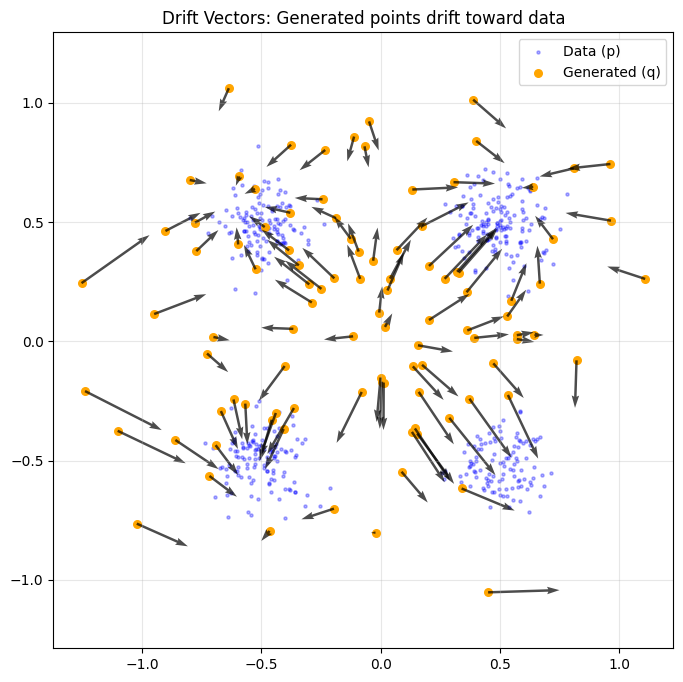

In [ ]:
# Quick visualization of drift vectors for ONE forward pass with simple 2D data and gen points.
torch.manual_seed(42)

# Random generated points (from Gaussian)
gen_test = torch.randn(100, 2) * 0.5

# Target data: simple 4-mode Gaussian mixture
centers = torch.tensor([[-0.5, -0.5], [-0.5, 0.5], [0.5, -0.5], [0.5, 0.5]])
idx = torch.randint(0, 4, (500,))
pos_test = centers[idx] + torch.randn(500, 2) * 0.1

# Compute drift
drift_test = compute_drift(gen_test, pos_test, temp=0.2)

# Plot
plt.figure(figsize=(8, 8))
plt.scatter(pos_test[:, 0], pos_test[:, 1], s=5, alpha=0.3, c='blue', label='Data (p)')
plt.scatter(gen_test[:, 0], gen_test[:, 1], s=30, c='orange', label='Generated (q)')
plt.quiver(gen_test[:, 0], gen_test[:, 1], drift_test[:, 0], drift_test[:, 1],
           scale=3, color='black', alpha=0.7, width=0.004)
plt.legend()
plt.title('Drift Vectors: Generated points drift toward data')
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

---

# Part 2: Toy 2D Examples

Let's train on 2D distributions to visualize the full training dynamics.

We'll use two classic test distributions:
- **Checkerboard**: 4 diagonally-arranged squares (tests mode coverage)
- **Swiss Roll**: Spiral pattern (tests learning complex geometry)

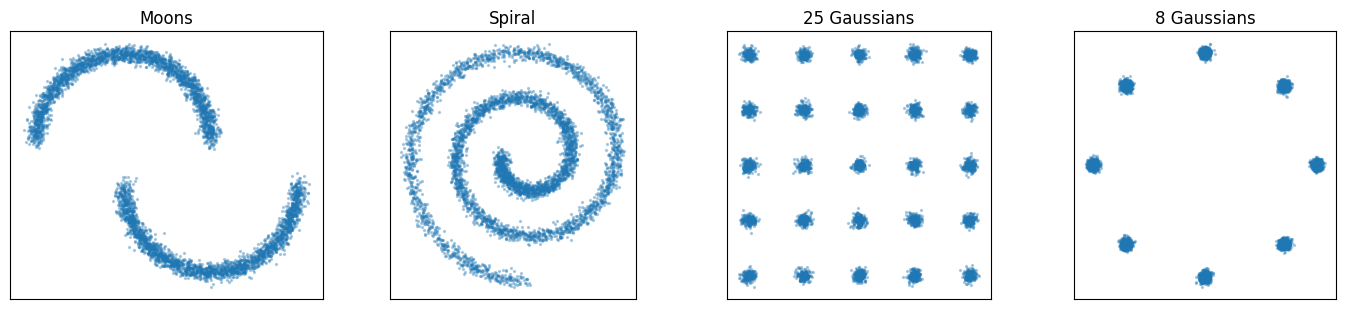

In [ ]:
# ============================================================
# Toy Dataset Samplers (4 benchmark datasets)
# ============================================================

def _normalize_points(pts: torch.Tensor) -> torch.Tensor:
    """
    Normalize point cloud to a roughly common scale.

        pts: [n, 2]

    Returns:
        pts_norm: [n, 2], approximately in [-1, 1]

        Different synthetic datasets naturally have different geometric scales.
        Normalizing keeps training dynamics comparable across datasets and methods.
    """
    scale = pts.abs().max().clamp_min(1e-8)
    return pts / scale


def sample_moons(
    n: int,
    noise: float = 0.05,
    generator: torch.Generator | None = None,
) -> torch.Tensor:
    """
    Sample a 2-moons dataset.

        n: number of points
        noise: Gaussian noise std added to coordinates
        generator: torch RNG for reproducible sampling

    Returns:
        pts: [n, 2]

    Construction:
        - Split into two groups n0 and n1
        - Moon 1: (cos t, sin t), t in [0, pi]
        - Moon 2: shifted/flipped arc: (1-cos t, -sin t-0.5)
        - Concatenate, add noise, center, normalize
    """
    n0 = n // 2
    n1 = n - n0

    t0 = math.pi * torch.rand(n0, generator=generator)
    moon0 = torch.stack([torch.cos(t0), torch.sin(t0)], dim=1)  # [n0, 2]

    t1 = math.pi * torch.rand(n1, generator=generator)
    moon1 = torch.stack([1.0 - torch.cos(t1), -torch.sin(t1) - 0.5], dim=1)  # [n1, 2]

    pts = torch.cat([moon0, moon1], dim=0)  # [n, 2]
    if noise > 0:
        pts = pts + noise * torch.randn(n, 2, generator=generator)

    # Center before scaling for cleaner alignment across runs
    pts = pts - pts.mean(dim=0, keepdim=True)
    return _normalize_points(pts)


def sample_spiral(
    n: int,
    noise: float = 0.03,
    generator: torch.Generator | None = None,
) -> torch.Tensor:
    """
    Sample a single 2D spiral.

        n: number of points
        noise: Gaussian noise std
        generator: torch RNG

    Returns:
        pts: [n, 2]

    Construction:
        - Sample u in [0,1], map to angle t
        - Radius increases with angle (r ~ t)
        - Coordinates: (r cos t, r sin t)
        - Add noise, center, normalize
    """
    u = torch.rand(n, generator=generator)
    t = 1.0 * math.pi + 4.5 * math.pi * u
    r = t / t.max().clamp_min(1e-8)

    pts = torch.stack([r * torch.cos(t), r * torch.sin(t)], dim=1)  # [n, 2]
    if noise > 0:
        pts = pts + noise * torch.randn(n, 2, generator=generator)

    pts = pts - pts.mean(dim=0, keepdim=True)
    return _normalize_points(pts)


def sample_25_gaussians(
    n: int,
    noise: float = 0.06,
    generator: torch.Generator | None = None,
) -> torch.Tensor:
    """
    Sample from a 5x5 grid of Gaussian modes (total 25 modes).

        n: number of points
        noise: Gaussian noise std around each selected center
        generator: torch RNG

    Returns:
        pts: [n, 2]

    Construction:
        - Build 25 centers on Cartesian grid {-2,-1,0,1,2} x {-2,-1,0,1,2}
        - Uniformly pick one center per sample
        - Add isotropic Gaussian noise
        - Normalize
    """
    coords = torch.linspace(-2.0, 2.0, steps=5)
    gx, gy = torch.meshgrid(coords, coords, indexing="ij")
    centers = torch.stack([gx.reshape(-1), gy.reshape(-1)], dim=1)  # [25, 2]

    idx = torch.randint(0, centers.shape[0], (n,), generator=generator)
    pts = centers[idx]  # [n, 2]
    if noise > 0:
        pts = pts + noise * torch.randn(n, 2, generator=generator)

    return _normalize_points(pts)


def sample_8_gaussians(
    n: int,
    noise: float = 0.05,
    generator: torch.Generator | None = None,
) -> torch.Tensor:
    """
    Sample from 8 Gaussian modes placed on a ring.

        n: number of points
        noise: Gaussian noise std around each selected center
        generator: torch RNG

    Returns:
        pts: [n, 2]

    Construction:
        - 8 equally-spaced angles on circle
        - Radius = 2.0 for centers
        - Uniformly choose one center per sample
        - Add isotropic Gaussian noise
        - Normalize
    """
    angles = torch.arange(8, dtype=torch.float32) * (2.0 * math.pi / 8.0)
    centers = 2.0 * torch.stack([torch.cos(angles), torch.sin(angles)], dim=1)  # [8, 2]

    idx = torch.randint(0, centers.shape[0], (n,), generator=generator)
    pts = centers[idx]  # [n, 2]
    if noise > 0:
        pts = pts + noise * torch.randn(n, 2, generator=generator)

    return _normalize_points(pts)


preview_sets = OrderedDict(
    {
        "Moons": sample_moons,
        "Spiral": sample_spiral,
        "25 Gaussians": sample_25_gaussians,
        "8 Gaussians": sample_8_gaussians,
    }
)

fig, axes = plt.subplots(1, 4, figsize=(14, 3.2))
for i, (name, sampler) in enumerate(preview_sets.items()):
    # fixed seed per panel so preview is deterministic
    g = torch.Generator(device="cpu").manual_seed(100 + i)
    pts = sampler(5000, generator=g).numpy()  # [5000, 2]

    ax = axes[i]
    ax.scatter(pts[:, 0], pts[:, 1], s=2, alpha=0.3)
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(name)

plt.tight_layout()
plt.show()


In [ ]:
# ============================================================
# Training Loop for Toy 2D 
# ============================================================

class MLP(nn.Module):
    """
    Generator network: z -> 2D point.

    Architecture:
        in_dim=32 -> hidden=256 -> hidden=256 -> hidden=256 -> out_dim=2
        Activations: SiLU between linear layers
            # MLP = Linear(in_dim, hidden)+SiLU
            #     -> Linear(hidden, hidden)+SiLU
            #     -> Linear(hidden, hidden)+SiLU
            #     -> Linear(hidden, 2)

    Shapes:
        input  z: [B, in_dim]  # latent noise vector    z ~ N(0, I)
        output x: [B, 2]       # generated 2D point
    """
    def __init__(self, in_dim=32, hidden=256, out_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, out_dim),
        )

    def forward(self, z):
        return self.net(z)


def emd_hungarian(x_np: np.ndarray, y_np: np.ndarray) -> float:
    """
    Exact EMD under equal-size, uniform-mass setting via Hungarian matching.

    Args:
        x_np: [n, 2] generated eval points
        y_np: [n, 2] target eval points

    Returns:
        scalar mean matching cost (L2 distance)
    """
    cost = np.linalg.norm(x_np[:, None, :] - y_np[None, :, :], axis=-1)  # [n, n]
    row, col = linear_sum_assignment(cost)
    return float(cost[row, col].mean())


def emd_ot(x_np: np.ndarray, y_np: np.ndarray) -> float:
    """
    Exact EMD via POT (ot.emd2), with uniform weights.

    Args:
        x_np: [n, 2]
        y_np: [m, 2]

    Returns:
        scalar OT cost
    """
    n, m = x_np.shape[0], y_np.shape[0]
    a = np.full(n, 1.0 / n, dtype=np.float64)  # source weights
    b = np.full(m, 1.0 / m, dtype=np.float64)  # target weights
    cost = np.linalg.norm(x_np[:, None, :] - y_np[None, :, :], axis=-1).astype(np.float64)  # [n, m]
    return float(ot.emd2(a, b, cost))


def _resolve_noise_device() -> torch.device:
    """
    Choose device for torch.Generator used by noise sampling.
    """
    return DEVICE if DEVICE.type in {"cpu", "cuda"} else torch.device("cpu")


def train_toy(
    sampler,
    steps: int = 1000,
    data_batch_size: int = 1024,
    gen_batch_size: int = 1024,
    lr: float = 1e-3,
    temp: float = 0.05,
    in_dim: int = 32,
    hidden: int = 256,
    seed: int = 42,
    method: str = "two_sided",
    sinkhorn_iters: int = 50,
    emd_eval_size: int = 64,
    emd_every: int = 1,
    data_seed_offset: int = 1000,
    noise_seed_offset: int = 2000,
    eval_data_seed_offset: int = 3000,
    eval_noise_seed_offset: int = 4000,
):
    """
    Train one model on one dataset with one drift method.

    Reproducibility:
    - same model init seed across methods
    - same training data stream seed across methods
    - same training noise stream seed across methods
    - fixed eval set (eval_pos, eval_z) per run for EMD tracking

    Returns:
        model: trained MLP
    """
    # 1) Model initialization (same seed => same initial weights)
    torch.manual_seed(seed)
    model = MLP(in_dim=in_dim, hidden=hidden, out_dim=2).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    # 2) RNG streams for strict comparability
    # data_rng: controls sampler randomness (CPU)
    # noise_rng: controls latent z randomness (CPU or CUDA)
    data_rng = torch.Generator(device="cpu").manual_seed(seed + data_seed_offset)
    noise_device = _resolve_noise_device()
    noise_rng = torch.Generator(device=noise_device).manual_seed(seed + noise_seed_offset)

    # 3) Fixed EMD evaluation set for this run
    # eval_pos: fixed target points
    # eval_z: fixed latent noise (model changes over time, z fixed)
    eval_data_rng = torch.Generator(device="cpu").manual_seed(seed + eval_data_seed_offset)
    eval_noise_rng = torch.Generator(device=noise_device).manual_seed(seed + eval_noise_seed_offset)
    eval_pos = sampler(emd_eval_size, generator=eval_data_rng).cpu().numpy()  # [E, 2]
    eval_z = torch.randn(emd_eval_size, in_dim, generator=eval_noise_rng, device=noise_device)  # [E, in_dim]
    if noise_device != DEVICE:
        eval_z = eval_z.to(DEVICE)

    # 4) Freeze method's parameters settings into compute_drift
    drift_fn = partial(
        compute_drift,
        temp=temp,
        method=method,
        sinkhorn_iters=sinkhorn_iters,
    )

    loss_history: list[float] = []
    emd_history_hung: list[float] = []
    emd_history_ot: list[float] = []
    emd_abs_diff_history: list[float] = []
    ema = None

    # 5) Main optimization loop
    pbar = tqdm(range(1, steps + 1), desc=f"{method}")
    for step in pbar:
        # 5.1 sample one mini-batch of target data
        pos = sampler(data_batch_size, generator=data_rng).to(DEVICE)  # [P, 2]

        # 5.2 sample latent noise and generate points
        z = torch.randn(gen_batch_size, in_dim, generator=noise_rng, device=noise_device)  # [G, in_dim]
        if noise_device != DEVICE:
            z = z.to(DEVICE)
        gen = model(z)  # [G, 2]

        # 5.3 drifting loss and parameter update
        # drifting_loss internally computes V and regresses gen -> gen+V target
        loss = drifting_loss(gen, pos, compute_drift=drift_fn)
        # clean last step grad, backward to cacluate this step grad, update parameters in model
        opt.zero_grad()
        loss.backward()
        opt.step()

        loss_history.append(float(loss.item()))
        ema = loss.item() if ema is None else 0.96 * ema + 0.04 * loss.item()

        # 5.4 periodic EMD evaluation on fixed eval set
        if step % emd_every == 0:
            with torch.no_grad():
                gen_eval = model(eval_z).detach().cpu().numpy()  # [E, 2]

            emd_h = emd_hungarian(gen_eval, eval_pos)
            emd_o = emd_ot(gen_eval, eval_pos)
            emd_d = abs(emd_h - emd_o)

            emd_history_hung.append(emd_h)
            emd_history_ot.append(emd_o)
            emd_abs_diff_history.append(emd_d)

            pbar.set_postfix(loss=f"{ema:.2e}", emd=f"{emd_h:.3f}", diff=f"{emd_d:.2e}")
        else:
            pbar.set_postfix(loss=f"{ema:.2e}")

    return model, loss_history, emd_history_hung, emd_history_ot, emd_abs_diff_history


=== Dataset: Moons ===
Training One-Sided ...


one_sided:   0%|          | 0/1000 [00:00<?, ?it/s]

  Hungarian vs ot.emd2 | mean abs diff=6.655e-09, max abs diff=7.938e-08
Training Two-Sided ...


two_sided:   0%|          | 0/1000 [00:00<?, ?it/s]

  Hungarian vs ot.emd2 | mean abs diff=6.766e-09, max abs diff=5.122e-08
Training Sinkhorn ...


sinkhorn:   0%|          | 0/1000 [00:00<?, ?it/s]

  Hungarian vs ot.emd2 | mean abs diff=6.662e-09, max abs diff=4.400e-08

=== Dataset: Spiral ===
Training One-Sided ...


one_sided:   0%|          | 0/1000 [00:00<?, ?it/s]

  Hungarian vs ot.emd2 | mean abs diff=6.809e-09, max abs diff=6.134e-08
Training Two-Sided ...


two_sided:   0%|          | 0/1000 [00:00<?, ?it/s]

  Hungarian vs ot.emd2 | mean abs diff=7.195e-09, max abs diff=3.427e-08
Training Sinkhorn ...


sinkhorn:   0%|          | 0/1000 [00:00<?, ?it/s]

  Hungarian vs ot.emd2 | mean abs diff=6.020e-09, max abs diff=3.577e-08

=== Dataset: 25 Gaussians ===
Training One-Sided ...


one_sided:   0%|          | 0/1000 [00:00<?, ?it/s]

  Hungarian vs ot.emd2 | mean abs diff=8.925e-09, max abs diff=6.746e-08
Training Two-Sided ...


two_sided:   0%|          | 0/1000 [00:00<?, ?it/s]

  Hungarian vs ot.emd2 | mean abs diff=7.949e-09, max abs diff=4.031e-08
Training Sinkhorn ...


sinkhorn:   0%|          | 0/1000 [00:00<?, ?it/s]

  Hungarian vs ot.emd2 | mean abs diff=6.830e-09, max abs diff=7.309e-08

=== Dataset: 8 Gaussians ===
Training One-Sided ...


one_sided:   0%|          | 0/1000 [00:00<?, ?it/s]

  Hungarian vs ot.emd2 | mean abs diff=1.086e-08, max abs diff=1.010e-07
Training Two-Sided ...


two_sided:   0%|          | 0/1000 [00:00<?, ?it/s]

  Hungarian vs ot.emd2 | mean abs diff=1.124e-08, max abs diff=8.784e-08
Training Sinkhorn ...


sinkhorn:   0%|          | 0/1000 [00:00<?, ?it/s]

  Hungarian vs ot.emd2 | mean abs diff=9.887e-09, max abs diff=5.588e-08


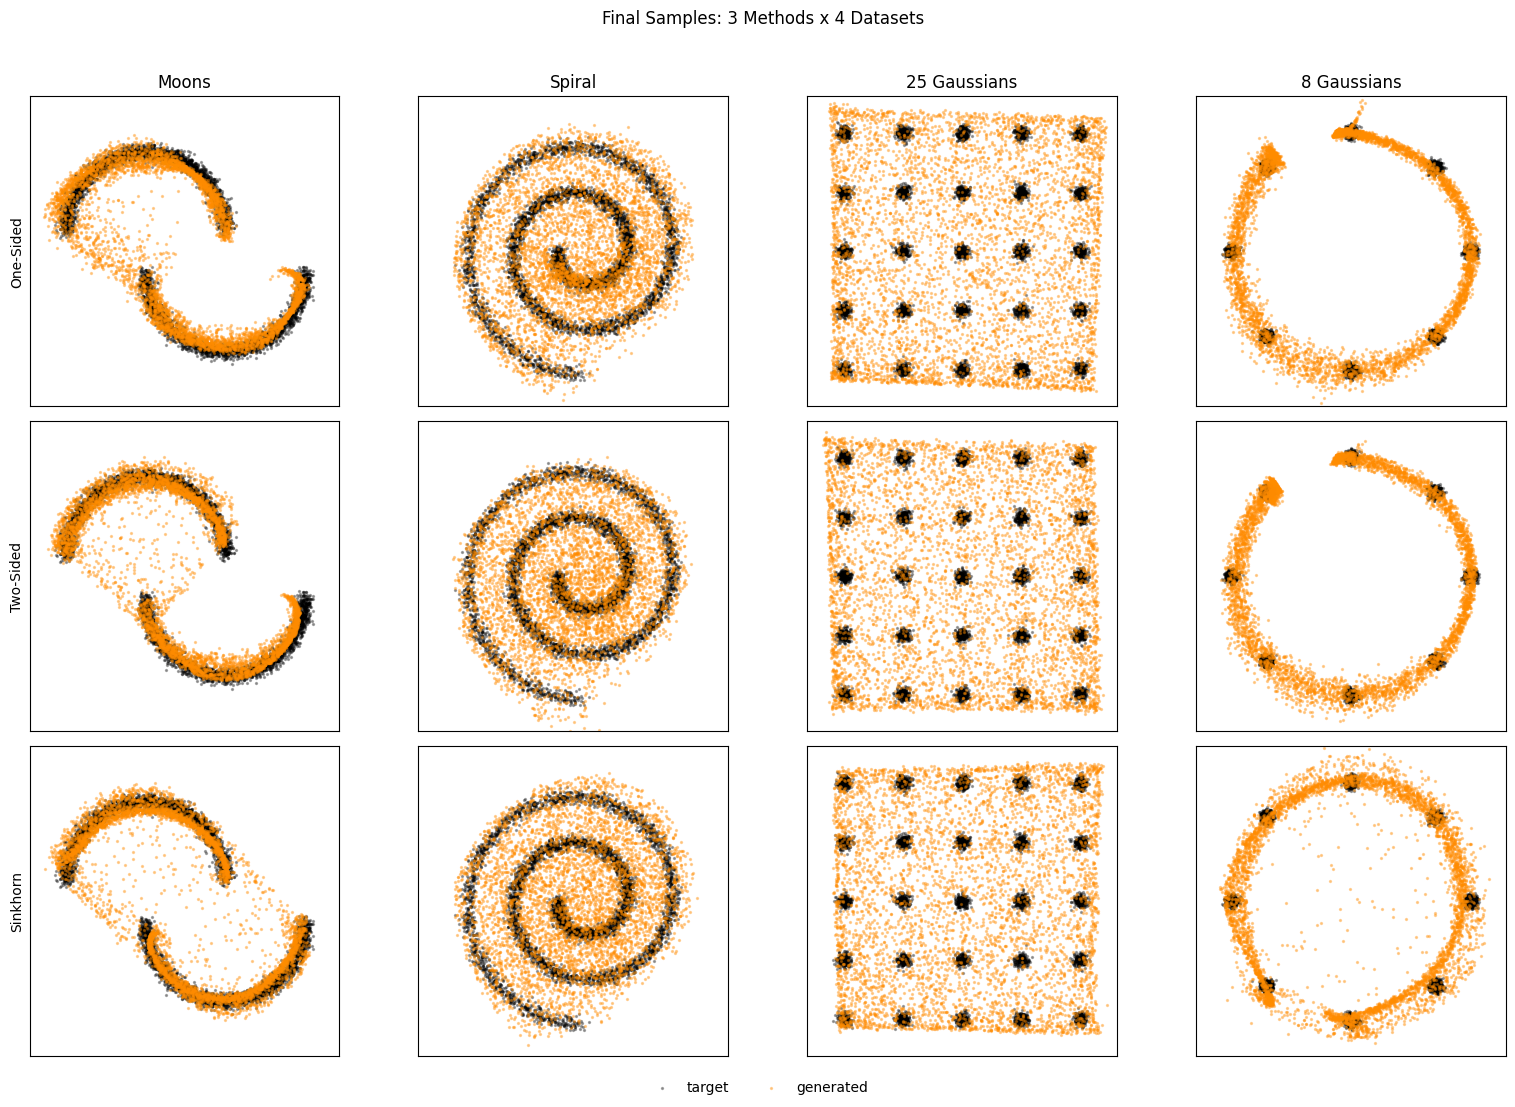

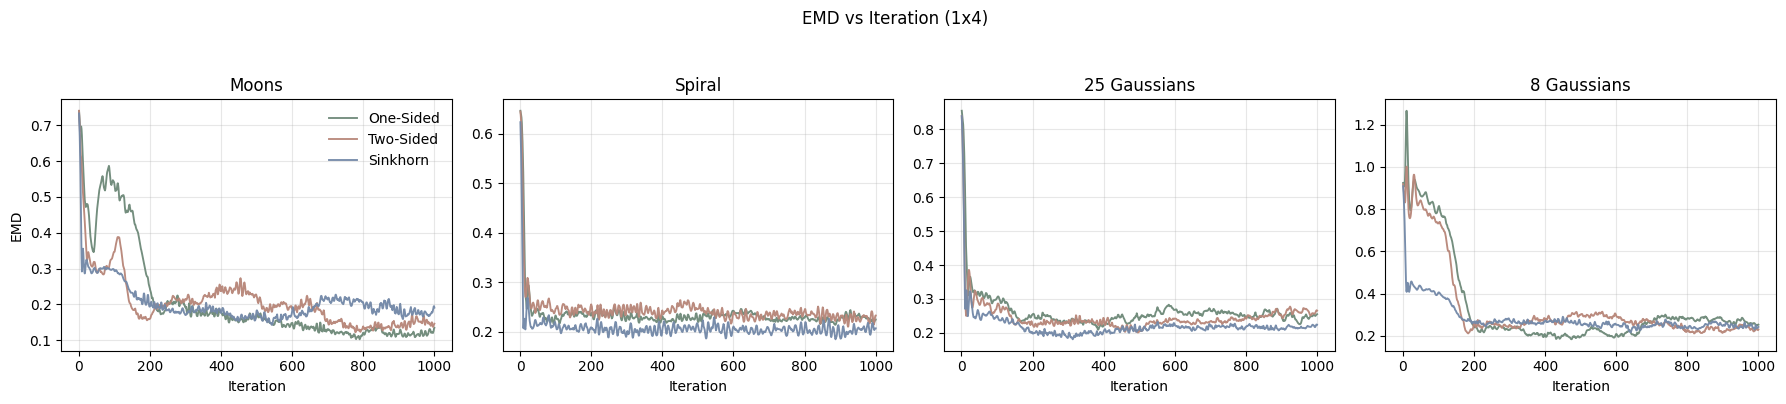

Saved: outputs/final_3x4.png
Saved: outputs/emd_1x4.png


In [ ]:
# 4 datasets x 3 methods benchmark and output figures
os.makedirs("outputs", exist_ok=True)


def run_benchmark(
    steps: int = 1000,          # Number of training iterations perrun.
    data_batch_size: int = 1024, # Target data batch size P used each training step.
                                 # pos shape in train loop: [P, 2].
    gen_batch_size: int = 1024,  # Generated batch size G used each training step.
                                 # z shape: [G, in_dim], gen shape: [G, 2].
    lr: float = 1e-3,            # Adam learning rate for updating MLP parameters.
    temp: float = 0.05,          # Drift temperature (like epsilon, log_T = -dist/temp):
    in_dim: int = 32,            # Latent noise dimension for generator input z.
                                 # z ~ N(0, I): [batch, in_dim].
    hidden: int = 256,           # MLP hidden width
                                 # MLP = Linear(in_dim, hidden)+SiLU
                                 #     -> Linear(hidden, hidden)+SiLU
                                 #     -> Linear(hidden, hidden)+SiLU
                                 #     -> Linear(hidden, 2)
    sinkhorn_iters: int = 50,    # Number of row/column normalization rounds in Sinkhorn plan.
    emd_eval_size: int = 64,     # Number of fixed eval points E used for per-iteration EMD.
                                 # eval_pos shape: [E, 2], eval_z shape: [E, in_dim].
    emd_every: int = 1,          # Evaluate EMD every N training steps.
    seed: int = 42,
):
    """
    Run the full toy generative modeling benchmark:
    - Datasets: Moons, Spiral, 25 Gaussians, 8 Gaussians
    - Methods: One-Sided, Two-Sided, Sinkhorn
    - Same model architecture and controlled random streams per run
    - Track EMD through training and save final plots
    """

    datasets = OrderedDict(
        {
            "Moons": sample_moons,
            "Spiral": sample_spiral,
            "25 Gaussians": sample_25_gaussians,
            "8 Gaussians": sample_8_gaussians,
        }
    )
    methods = OrderedDict(
        {
            "One-Sided": "one_sided",
            "Two-Sided": "two_sided",
            "Sinkhorn": "sinkhorn",
        }
    )

    # Morandi-style but clearly separated colors
    method_colors = {
        "One-Sided": "#6F8A7A",  # muted sage
        "Two-Sided": "#B8877A",  # dusty terracotta
        "Sinkhorn": "#7489A8",   # muted slate blue
    }

    results = {}
    for dataset_label, sampler in datasets.items():
        print(f"\n=== Dataset: {dataset_label} ===")
        for method_label, method_key in methods.items():
            print(f"Training {method_label} ...")
            model, loss_history, emd_history_hung, emd_history_ot, emd_abs_diff_history = train_toy(
                sampler=sampler,
                steps=steps,
                data_batch_size=data_batch_size,
                gen_batch_size=gen_batch_size,
                lr=lr,
                temp=temp,
                in_dim=in_dim,
                hidden=hidden,
                seed=seed,
                method=method_key,
                sinkhorn_iters=sinkhorn_iters,
                emd_eval_size=emd_eval_size,
                emd_every=emd_every,
            )

            diff_mean = float(np.mean(emd_abs_diff_history))
            diff_max = float(np.max(emd_abs_diff_history))
            print(f"  Hungarian vs ot.emd2 | mean abs diff={diff_mean:.3e}, max abs diff={diff_max:.3e}")

            results[(method_label, dataset_label)] = {
                "model": model,
                "loss_history": loss_history,
                "emd_history": emd_history_hung,
                "emd_history_ot": emd_history_ot,
                "emd_abs_diff_history": emd_abs_diff_history,
            }

    # Fixed visualization samples for comparability.
    vis_targets = {}
    for ci, (dataset_label, sampler) in enumerate(datasets.items()):
        g = torch.Generator(device="cpu").manual_seed(seed + 5000 + ci)
        vis_targets[dataset_label] = sampler(5000, generator=g).cpu().numpy()

    vis_noise_device = _resolve_noise_device()

    # ------------------------------------------------------------
    # final_3x4: rows=methods, cols=datasets
    # ------------------------------------------------------------
    fig, axes = plt.subplots(len(methods), len(datasets), figsize=(16, 11), sharex=True, sharey=True)
    if len(methods) == 1:
        axes = axes[None, :]

    for ri, (method_label, _) in enumerate(methods.items()):
        for ci, (dataset_label, _) in enumerate(datasets.items()):
            ax = axes[ri, ci]
            model = results[(method_label, dataset_label)]["model"]

            g = torch.Generator(device=vis_noise_device).manual_seed(seed + 6000 + ci)
            z = torch.randn(5000, in_dim, generator=g, device=vis_noise_device)
            if vis_noise_device != DEVICE:
                z = z.to(DEVICE)
            with torch.no_grad():
                gen_vis = model(z).cpu().numpy()

            target_vis = vis_targets[dataset_label]
            ax.scatter(target_vis[:, 0], target_vis[:, 1], s=2, alpha=0.30, c="black", label="target")
            ax.scatter(gen_vis[:, 0], gen_vis[:, 1], s=2, alpha=0.35, c="darkorange", label="generated")
            ax.set_xlim(-1.2, 1.2)
            ax.set_ylim(-1.2, 1.2)
            ax.set_aspect("equal")
            ax.set_xticks([])
            ax.set_yticks([])

            if ri == 0:
                ax.set_title(dataset_label)
            if ci == 0:
                ax.set_ylabel(method_label)

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=2, frameon=False)
    fig.suptitle("Final Samples: 3 Methods x 4 Datasets", y=0.995)
    fig.tight_layout(rect=[0, 0.03, 1, 0.98])
    fig.savefig("outputs/final_3x4.png", dpi=220)
    plt.show()

    # ------------------------------------------------------------
    # emd_1x4: one panel per dataset with 3 method curves
    # ------------------------------------------------------------
    fig, axes = plt.subplots(1, len(datasets), figsize=(18, 3.8), sharey=False)
    if len(datasets) == 1:
        axes = [axes]

    x_axis = np.arange(emd_every, steps + 1, emd_every)
    for ci, (dataset_label, _) in enumerate(datasets.items()):
        ax = axes[ci]
        for method_label in methods.keys():
            emd_hist = results[(method_label, dataset_label)]["emd_history"]
            ax.plot(
                x_axis[: len(emd_hist)],
                emd_hist,
                linewidth=1.35,
                alpha=0.97,
                color=method_colors[method_label],
                label=method_label,
            )
        ax.set_title(dataset_label)
        ax.set_xlabel("Iteration")
        if ci == 0:
            ax.set_ylabel("EMD")
        ax.grid(True, alpha=0.3)

    axes[0].legend(frameon=False)
    fig.suptitle("EMD vs Iteration (1x4)", y=1.05)
    fig.tight_layout()
    fig.savefig("outputs/emd_1x4.png", dpi=220)
    plt.show()

    return results


benchmark_results = run_benchmark(
    steps=1000,
    data_batch_size=1024,
    gen_batch_size=1024,
    lr=1e-3,
    temp=0.05,
    in_dim=32,
    hidden=256,
    sinkhorn_iters=50,
    emd_eval_size=64,
    emd_every=1,
    seed=42,
)

print("Saved: outputs/final_3x4.png")
print("Saved: outputs/emd_1x4.png")


=== Dataset: Moons ===
Training One-Sided ...


one_sided:   0%|          | 0/10000 [00:00<?, ?it/s]

one_sided: 100%|██████████| 10000/10000 [01:25<00:00, 117.42it/s, diff=1.00e-09, emd=0.165, loss=4.00e-04]


  Hungarian vs ot.emd2 | mean abs diff=5.758e-09, max abs diff=5.588e-08
Training Two-Sided ...


two_sided: 100%|██████████| 10000/10000 [01:27<00:00, 114.39it/s, diff=7.81e-09, emd=0.159, loss=4.47e-04]


  Hungarian vs ot.emd2 | mean abs diff=6.167e-09, max abs diff=6.659e-08
Training Sinkhorn ...


sinkhorn: 100%|██████████| 10000/10000 [02:26<00:00, 68.08it/s, diff=2.84e-09, emd=0.165, loss=1.08e-03] 


  Hungarian vs ot.emd2 | mean abs diff=5.767e-09, max abs diff=3.580e-08

=== Dataset: Spiral ===
Training One-Sided ...


one_sided: 100%|██████████| 10000/10000 [00:17<00:00, 563.80it/s, diff=5.17e-09, emd=0.219, loss=3.15e-04]


  Hungarian vs ot.emd2 | mean abs diff=6.258e-09, max abs diff=5.332e-08
Training Two-Sided ...


two_sided: 100%|██████████| 10000/10000 [00:18<00:00, 533.24it/s, diff=7.23e-09, emd=0.208, loss=3.89e-04]


  Hungarian vs ot.emd2 | mean abs diff=5.985e-09, max abs diff=5.169e-08
Training Sinkhorn ...


sinkhorn: 100%|██████████| 10000/10000 [01:26<00:00, 115.26it/s, diff=1.31e-08, emd=0.208, loss=5.72e-04]


  Hungarian vs ot.emd2 | mean abs diff=5.918e-09, max abs diff=5.227e-08

=== Dataset: 25 Gaussians ===
Training One-Sided ...


one_sided: 100%|██████████| 10000/10000 [00:17<00:00, 565.99it/s, diff=4.66e-10, emd=0.232, loss=7.24e-04]


  Hungarian vs ot.emd2 | mean abs diff=6.553e-09, max abs diff=5.908e-08
Training Two-Sided ...


two_sided: 100%|██████████| 10000/10000 [00:18<00:00, 535.61it/s, diff=3.54e-09, emd=0.246, loss=7.39e-04]


  Hungarian vs ot.emd2 | mean abs diff=7.944e-09, max abs diff=5.761e-08
Training Sinkhorn ...


sinkhorn: 100%|██████████| 10000/10000 [01:26<00:00, 115.45it/s, diff=9.60e-10, emd=0.215, loss=1.89e-03]


  Hungarian vs ot.emd2 | mean abs diff=6.587e-09, max abs diff=4.686e-08

=== Dataset: 8 Gaussians ===
Training One-Sided ...


one_sided: 100%|██████████| 10000/10000 [00:17<00:00, 572.83it/s, diff=2.40e-09, emd=0.263, loss=5.21e-04]


  Hungarian vs ot.emd2 | mean abs diff=9.141e-09, max abs diff=4.657e-08
Training Two-Sided ...


two_sided: 100%|██████████| 10000/10000 [00:18<00:00, 533.18it/s, diff=1.98e-09, emd=0.213, loss=4.86e-04]


  Hungarian vs ot.emd2 | mean abs diff=9.493e-09, max abs diff=5.064e-08
Training Sinkhorn ...


sinkhorn: 100%|██████████| 10000/10000 [01:27<00:00, 114.77it/s, diff=1.36e-09, emd=0.245, loss=1.89e-03]


  Hungarian vs ot.emd2 | mean abs diff=9.801e-09, max abs diff=5.099e-08


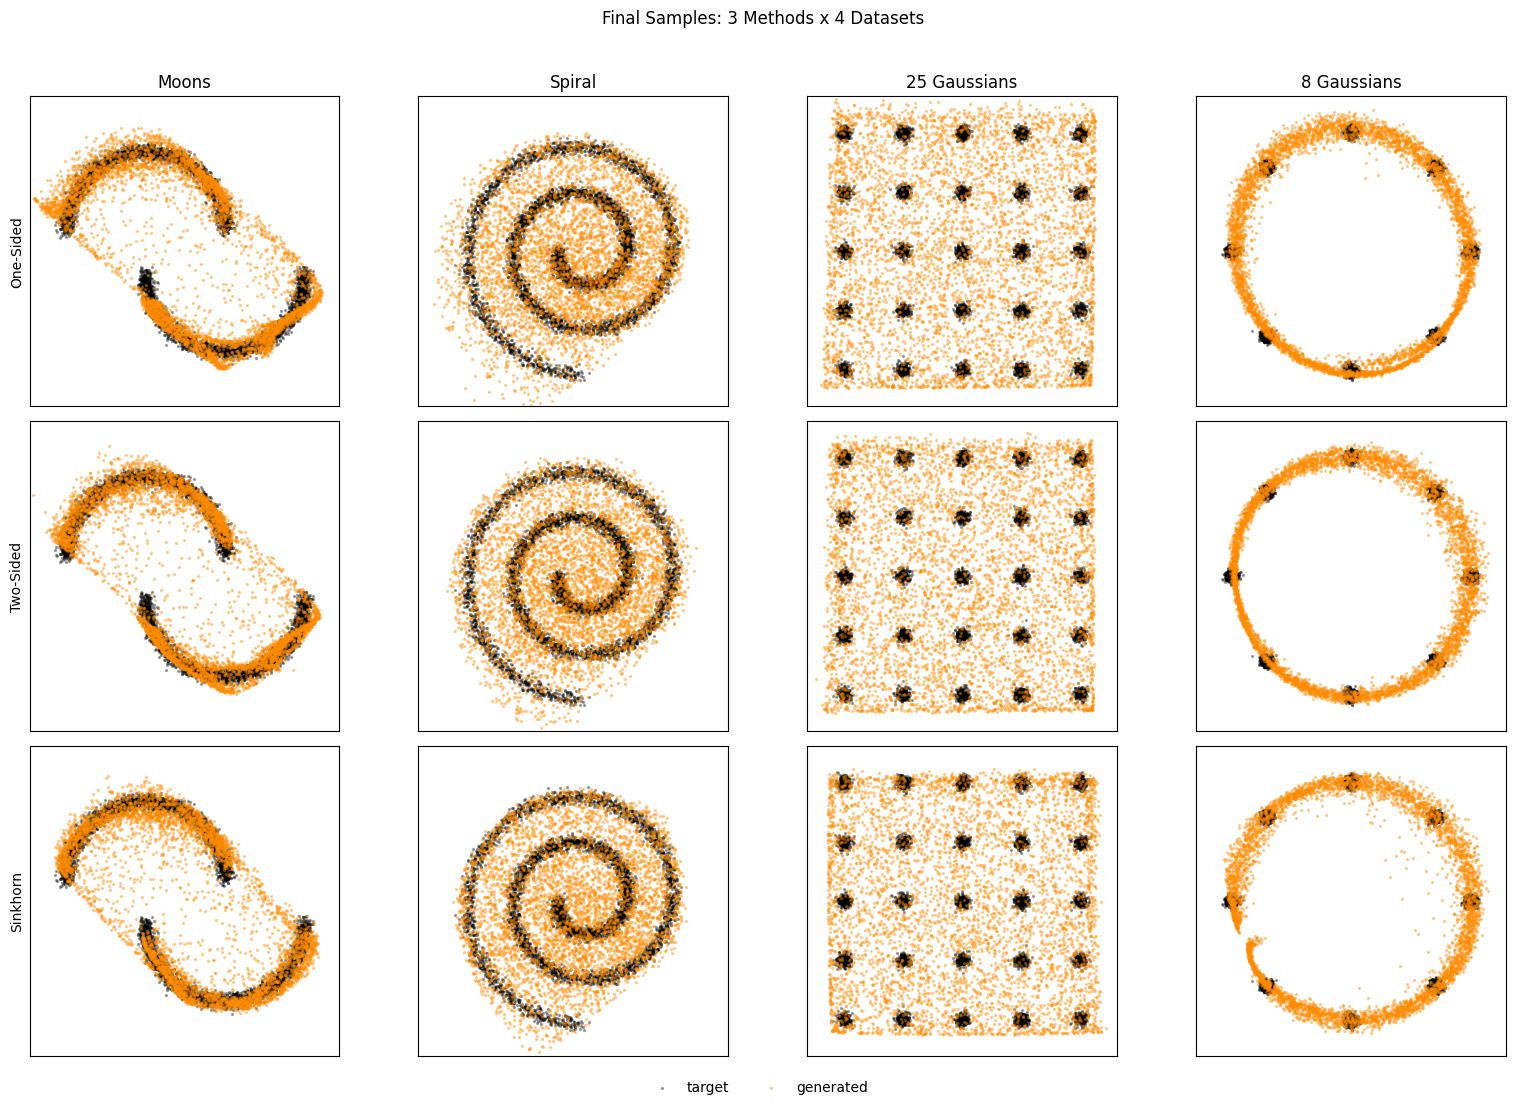

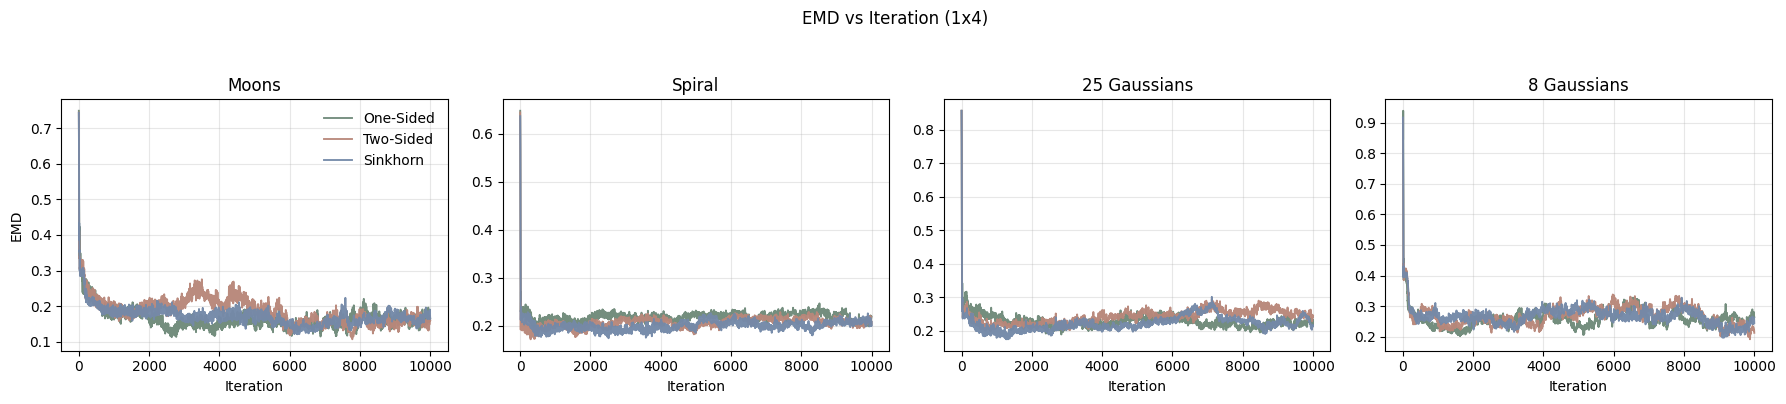

In [12]:
# 4 datasets x 3 methods benchmark and output figures
os.makedirs("outputs", exist_ok=True)


def run_benchmark(
    steps: int = 10000,
    data_batch_size: int = 1024,
    gen_batch_size: int = 1024,
    lr: float = 1e-3,
    temp: float = 0.05,
    in_dim: int = 32,
    hidden: int = 256,
    sinkhorn_iters: int = 50,
    emd_eval_size: int = 64,
    emd_every: int = 1,
    seed: int = 42,
):
    datasets = OrderedDict(
        {
            "Moons": sample_moons,
            "Spiral": sample_spiral,
            "25 Gaussians": sample_25_gaussians,
            "8 Gaussians": sample_8_gaussians,
        }
    )
    methods = OrderedDict(
        {
            "One-Sided": "one_sided",
            "Two-Sided": "two_sided",
            "Sinkhorn": "sinkhorn",
        }
    )

    # Morandi-style but clearly separated colors
    method_colors = {
        "One-Sided": "#6F8A7A",  # muted sage
        "Two-Sided": "#B8877A",  # dusty terracotta
        "Sinkhorn": "#7489A8",   # muted slate blue
    }

    results = {}
    for dataset_label, sampler in datasets.items():
        print(f"\n=== Dataset: {dataset_label} ===")
        for method_label, method_key in methods.items():
            print(f"Training {method_label} ...")
            model, loss_history, emd_history_hung, emd_history_ot, emd_abs_diff_history = train_toy(
                sampler=sampler,
                steps=steps,
                data_batch_size=data_batch_size,
                gen_batch_size=gen_batch_size,
                lr=lr,
                temp=temp,
                in_dim=in_dim,
                hidden=hidden,
                seed=seed,
                method=method_key,
                sinkhorn_iters=sinkhorn_iters,
                emd_eval_size=emd_eval_size,
                emd_every=emd_every,
            )

            diff_mean = float(np.mean(emd_abs_diff_history))
            diff_max = float(np.max(emd_abs_diff_history))
            print(f"  Hungarian vs ot.emd2 | mean abs diff={diff_mean:.3e}, max abs diff={diff_max:.3e}")

            results[(method_label, dataset_label)] = {
                "model": model,
                "loss_history": loss_history,
                "emd_history": emd_history_hung,
                "emd_history_ot": emd_history_ot,
                "emd_abs_diff_history": emd_abs_diff_history,
            }

    # Fixed visualization samples for comparability.
    vis_targets = {}
    for ci, (dataset_label, sampler) in enumerate(datasets.items()):
        g = torch.Generator(device="cpu").manual_seed(seed + 5000 + ci)
        vis_targets[dataset_label] = sampler(5000, generator=g).cpu().numpy()

    vis_noise_device = _resolve_noise_device()

    # ------------------------------------------------------------
    # final_3x4: rows=methods, cols=datasets
    # ------------------------------------------------------------
    fig, axes = plt.subplots(len(methods), len(datasets), figsize=(16, 11), sharex=True, sharey=True)
    if len(methods) == 1:
        axes = axes[None, :]

    for ri, (method_label, _) in enumerate(methods.items()):
        for ci, (dataset_label, _) in enumerate(datasets.items()):
            ax = axes[ri, ci]
            model = results[(method_label, dataset_label)]["model"]

            g = torch.Generator(device=vis_noise_device).manual_seed(seed + 6000 + ci)
            z = torch.randn(5000, in_dim, generator=g, device=vis_noise_device)
            if vis_noise_device != DEVICE:
                z = z.to(DEVICE)
            with torch.no_grad():
                gen_vis = model(z).cpu().numpy()

            target_vis = vis_targets[dataset_label]
            ax.scatter(target_vis[:, 0], target_vis[:, 1], s=2, alpha=0.30, c="black", label="target")
            ax.scatter(gen_vis[:, 0], gen_vis[:, 1], s=2, alpha=0.35, c="darkorange", label="generated")
            ax.set_xlim(-1.2, 1.2)
            ax.set_ylim(-1.2, 1.2)
            ax.set_aspect("equal")
            ax.set_xticks([])
            ax.set_yticks([])

            if ri == 0:
                ax.set_title(dataset_label)
            if ci == 0:
                ax.set_ylabel(method_label)

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=2, frameon=False)
    fig.suptitle("Final Samples: 3 Methods x 4 Datasets", y=0.995)
    fig.tight_layout(rect=[0, 0.03, 1, 0.98])
    fig.savefig("outputs/final_3x4.png", dpi=220)
    plt.show()

    # ------------------------------------------------------------
    # emd_1x4: one panel per dataset with 3 method curves
    # ------------------------------------------------------------
    fig, axes = plt.subplots(1, len(datasets), figsize=(18, 3.8), sharey=False)
    if len(datasets) == 1:
        axes = [axes]

    x_axis = np.arange(emd_every, steps + 1, emd_every)
    for ci, (dataset_label, _) in enumerate(datasets.items()):
        ax = axes[ci]
        for method_label in methods.keys():
            emd_hist = results[(method_label, dataset_label)]["emd_history"]
            ax.plot(
                x_axis[: len(emd_hist)],
                emd_hist,
                linewidth=1.35,
                alpha=0.97,
                color=method_colors[method_label],
                label=method_label,
            )
        ax.set_title(dataset_label)
        ax.set_xlabel("Iteration")
        if ci == 0:
            ax.set_ylabel("EMD")
        ax.grid(True, alpha=0.3)

    axes[0].legend(frameon=False)
    fig.suptitle("EMD vs Iteration (1x4)", y=1.05)
    fig.tight_layout()
    fig.savefig("outputs/emd_1x4.png", dpi=220)
    plt.show()

    return results


benchmark_results = run_benchmark(
    steps=10000,
    data_batch_size=1024,
    gen_batch_size=1024,
    lr=1e-3,
    temp=0.5,
    in_dim=32,
    hidden=256,
    sinkhorn_iters=50,
    emd_eval_size=64,
    emd_every=1,
    seed=42,
)